In [99]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
(32,)
[0 1 0 0 1 1 0 1 1 0 2 0 0 1 1 0 2 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1]


2025-08-16 10:28:21.626703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


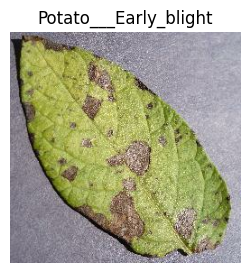

In [28]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    # print(image_batch[0].numpy())
    print(label_batch.numpy())
    plt.figure(figsize=(3,3))
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

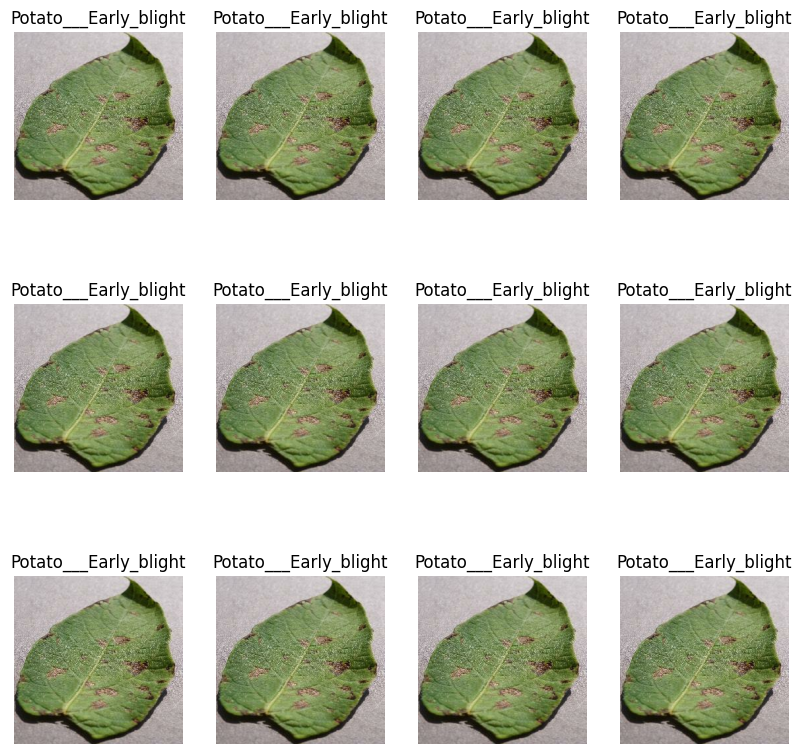

In [38]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [39]:
len(dataset)

68

In [40]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [52]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
len(test_ds)
val_size=0.1
print(len(dataset)*val_size)
val_ds = dataset.take(6)
test_ds = test_ds.skip(6)
print(len(val_ds))
print(len(test_ds))

6.800000000000001
6
8


In [53]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [54]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [56]:
len(train_ds)
len(test_ds)
len(val_ds)

6

In [57]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [70]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,2), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/opt/homebrew/Cellar/jupyterlab/4.4.5/libexec/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [101]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.9693 - loss: 0.0916 - val_accuracy: 0.9531 - val_loss: 0.1463
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.9560 - loss: 0.1302 - val_accuracy: 0.8385 - val_loss: 0.4150
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.9734 - loss: 0.0796 - val_accuracy: 0.8542 - val_loss: 0.4982
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.9693 - loss: 0.0848 - val_accuracy: 0.9323 - val_loss: 0.2110
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.9734 - loss: 0.0747 - val_accuracy: 0.9167 - val_loss: 0.3021
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.9589 - loss: 0.1218 - val_accuracy: 0.9062 - val_loss: 0.3106
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.9751 - loss: 0.0742 - val_accuracy: 0.9219 - val_loss: 0.2897
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.9745 - loss: 0.0688 - val_accu

In [102]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8945 - loss: 0.3468


In [103]:
history

In [104]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [105]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [106]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation Loss')

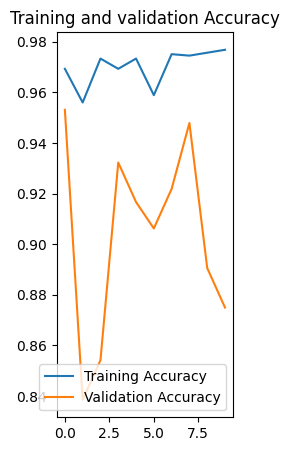

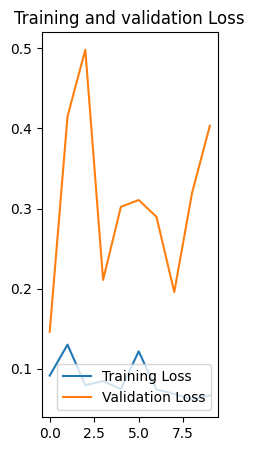

In [108]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label="Training Accuracy")
plt.plot(range(10), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation Accuracy")

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(10), loss, label="Training Loss")
plt.plot(range(10), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and validation Loss")

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Potato___Early_blight


2025-08-16 15:08:57.979214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


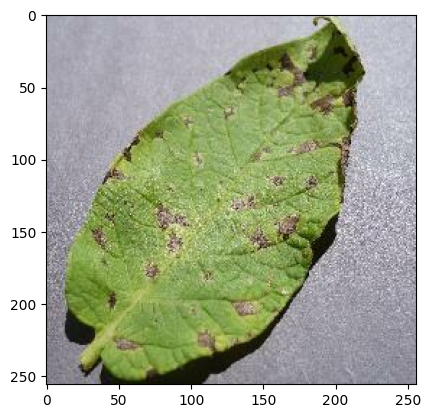

In [113]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [123]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


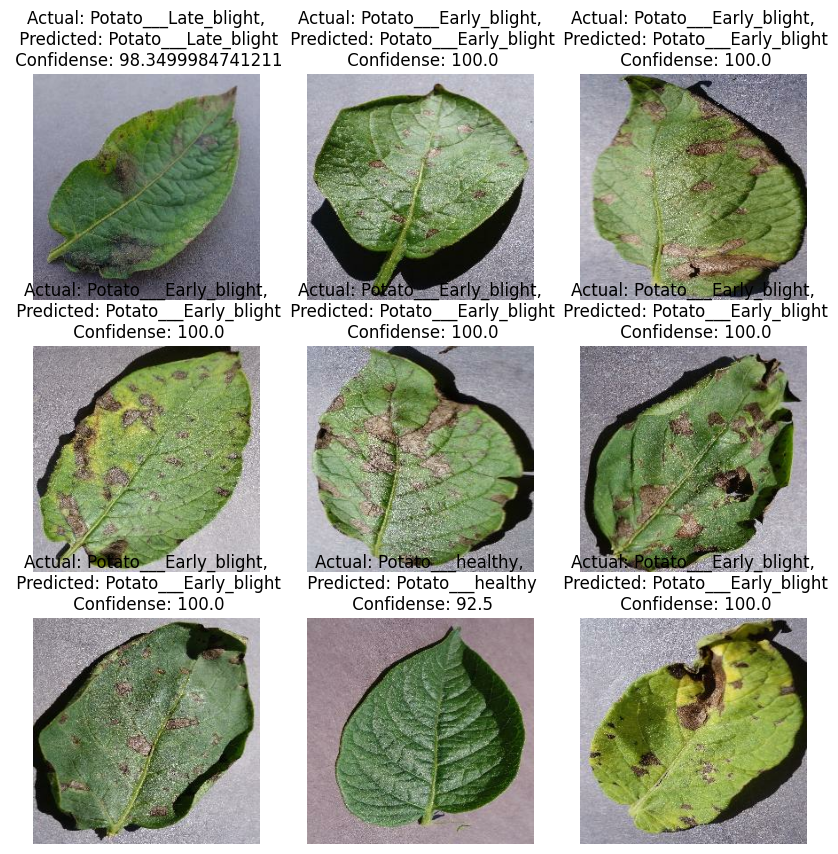

In [125]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidense = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]  
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidense: {confidense}")
        plt.axis("off")

In [137]:
import os
model_version = 1
model.save(f"../projects/potato-disease/models/{model_version}.h5")